### The Heatmap Implementation!!!
#### By: Madison Mina
Now we are going to use the Keras implementation of Grad-CAM++ (Thanks Sam!)

In [49]:
import sys
sys.path.append("/home/ad.msoe.edu/minam/tf.keras-gradcamplusplus")

from gradcam import grad_cam, grad_cam_plus
from utils import show_imgwithheat

Bad news… the model isn’t working as-is because the feature extractor layer is frozen. I’ll need to build my own CNN from scratch so we can train properly and get the heatmaps we need.

In [50]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models


class DefectDetector:
    IMG_SIZE = 224

    def __init__(self, train_path):

        #  Data loader
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            validation_split=0.1
        )

        self.train_data = datagen.flow_from_directory(
            train_path,
            target_size=(self.IMG_SIZE, self.IMG_SIZE),
            batch_size=16,
            class_mode="sparse",
            subset="training"
        )

        self.val_data = datagen.flow_from_directory(
            train_path,
            target_size=(self.IMG_SIZE, self.IMG_SIZE),
            batch_size=16,
            class_mode="sparse",
            subset="validation"
        )

        self.class_indices = self.train_data.class_indices
        num_classes = len(self.class_indices)

        self._build_full_cnn(num_classes)
        self._train()

    def _build_full_cnn(self, num_classes):

        base = MobileNetV2(
            input_shape=(224, 224, 3),
            include_top=False,
            weights="imagenet"
        )

        base.trainable = False 

        x = layers.GlobalAveragePooling2D()(base.output)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(num_classes, activation="softmax")(x)

        self.model = tf.keras.Model(inputs=base.input, outputs=outputs)

        self.model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

    #  Training
    def _train(self):
        self.model.fit(
            self.train_data,
            validation_data=self.val_data,
            epochs=8
        )

    #  Preprocessing
    def preprocess_image(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = img.astype(np.float32) / 255.0
        return img

    #  Prediction
    def predict(self, image_path):
        img = self.preprocess_image(image_path)
        img = np.expand_dims(img, axis=0)

        probs = self.model.predict(img, verbose=0)
        class_idx = np.argmax(probs)

        idx_to_class = {v: k for k, v in self.class_indices.items()}
        predicted_class = idx_to_class[class_idx]

        return predicted_class, probs[0][class_idx]


In [52]:
train_path = "jarlids_crops/train"
detector = DefectDetector(train_path=train_path)

Found 1671 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Epoch 1/8


2025-12-06 03:17:41.037588: I external/local_xla/xla/service/service.cc:163] XLA service 0x7378d0002c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-06 03:17:41.037611: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-12-06 03:17:41.037631: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2025-12-06 03:17:41.037636: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2025-12-06 03:17:41.037640: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (3): Tesla T4, Compute Capability 7.5
2025-12-06 03:17:41.155421: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-06 03:17:41.896974: I external/local_xla/xla/stream_executo

 20/105 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.5959 - loss: 1.0161

2025-12-06 03:17:58.006654: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-06 03:17:58.151381: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-06 03:17:58.288603: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6763 - loss: 0.7433

2025-12-06 03:18:32.445762: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-06 03:18:32.583326: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


105/105 ━━━━━━━━━━━━━━━━━━━━ 57s 433ms/step - accuracy: 0.7379 - loss: 0.5687 - val_accuracy: 0.7826 - val_loss: 0.4454
Epoch 2/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 25s 233ms/step - accuracy: 0.8444 - loss: 0.3708 - val_accuracy: 0.7500 - val_loss: 0.6273
Epoch 3/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 23s 222ms/step - accuracy: 0.8450 - loss: 0.3554 - val_accuracy: 0.7935 - val_loss: 0.5358
Epoch 4/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 263ms/step - accuracy: 0.8624 - loss: 0.3168 - val_accuracy: 0.8261 - val_loss: 0.4143
Epoch 5/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 26s 251ms/step - accuracy: 0.8594 - loss: 0.3057 - val_accuracy: 0.8315 - val_loss: 0.4286
Epoch 6/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 269ms/step - accuracy: 0.8630 - loss: 0.3111 - val_accuracy: 0.7500 - val_loss: 0.5512
Epoch 7/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 259ms/step - accuracy: 0.8905 - loss: 0.2646 - val_accuracy: 0.7935 - val_loss: 0.4369
Epoch 8/8
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 267ms/step - accuracy: 0.8809 - loss: 0.2764 - val_accura

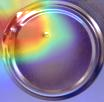

In [66]:
image_path = "jarlids_crops/damaged/crop_1703.jpg"
img = detector.preprocess_image(image_path)

heatmap = grad_cam(
    detector.model,
    img,  
    layer_name="Conv_1" 
)

show_imgwithheat(image_path, heatmap)


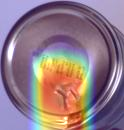

In [69]:
image_path = "jarlids_crops/damaged/crop_1755.jpg"
img = detector.preprocess_image(image_path)

heatmap = grad_cam(
    detector.model,
    img,  
    layer_name="Conv_1" 
)

show_imgwithheat(image_path, heatmap)


# This cell is too big in size when ran... 
import os

dataset_path = "jarlids_crops/damaged"

for img_name in os.listdir(dataset_path):
    if not img_name.lower().endswith(".jpg"):
        continue

    image_path = os.path.join(dataset_path, img_name)

    # Preprocess image
    img = detector.preprocess_image(image_path)

    # Generate Grad-CAM heatmap
    heatmap = grad_cam(
        detector.model,
        img,
        layer_name="Conv_1"
    )

    # Show heatmap overlay
    show_imgwithheat(image_path, heatmap)

Wow that was a lot... but hey, we are done now :D